# Scientific visualizations with `alphatools` 

In this tutorial, we will explore `alphatools`' plotting functionalities. It is built inspired by the [`stylia`] package, and relies on two key principles:

1. Use matplotlib `Figure` and `Axes` directly wherever possible, which enables users to extend the `alphatools` core plots with their own visualizations, while benefiting from the unified styling and coloring - this will make your figures and panels look like they are 'cut from the same cloth' rather than a patchwork of slightly different layouts.

2. Follow *modular design*: Instead of making highly complex, increasingly large 'does-everything' methods (e.g. a volcanoplot that performs filtering, ttest, labelling and visualization all at once), `alphatools` relies on the separation of concerns, leading to significantly smaller functions from which plots can be built in a LEGO-like principle, and where custom functionalities can easily be added.

---

We distinguish between *Color Palettes* and *Colormaps*: The former are finite lists of RGBA tuple colors, while the latter are a continuous gradients from which an arbitrary number of colors can be sampled. `alphatools` provides the following presets:

- Single primary colors: Stylized versions of primary colors based on the *Spectral* colormap
- Color palettes:
  - binary color palette: two colors for maximum separability (e.g. for a volcanoplot's up- and downregulated points)
  - qualitative color palette: 9 colors to color different data levels (e.g. for different disease states or batches)
- Colormaps:
  - sequential: A gradient to color numeric values (e.g. map a continuous variable in a UMAP)
  - diverging: A gradient with two distinct sides and a middle, to map numeric values around a center (e.g. in a heatmap)

--> Highly recommended read on a lot of the color choices presented below: https://www.fabiocrameri.ch/colourmaps/ in this, Fabio Crameri outlines the deceptive nature of some default colorscales used in science and gives perceptually uniform, color vision deficiency (CVD) friendly alternatives


[`stylia`]: https://github.com/ersilia-os/stylia.git

In [ ]:
%load_ext autoreload
%autoreload 2

import logging

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

from alphatools.pl import colors
from alphatools.pl.colors import show_rgba_color_list, BaseColors
from alphatools.pl.figure import create_figure, label_axes, save_figure
from alphatools.pl.plots import Plots, label_plot
from alphatools.pp.data import add_metadata

logging.basicConfig(level=logging.INFO)

## Primary colors in `alphatools`

The 'spectral' colorscale was used to obtain a set of distinct primary colors, all of which can be accessed via `BaseColors.get(<colorname>)`.

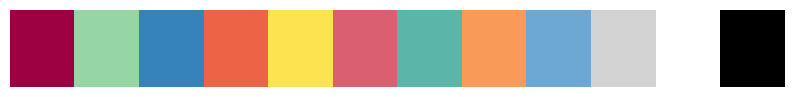

In [ ]:
base_colors = [
    "red",
    "lightgreen",
    "blue",
    "orange",
    "yellow",
    "lightred",
    "green",
    "lightorange",
    "lightblue",
    "grey",
    "white",
    "black",
]
show_rgba_color_list([colors.BaseColors.get(base_color) for base_color in base_colors])

## Scientific colors in `alphatools`

Aside from primary colors, plots often require coloring in two or more levels in a distinct manner. The perceptually uniform colorscales of https://github.com/callumrollo/cmcrameri.git (`cmcrameri` package) are aesthetic while at the same time adhering to best practices for color vision deficiencies (CVDs) and greyscale readability. 

### First, we introduce a simple binary palette, good for coloring 'up-down' type plots:

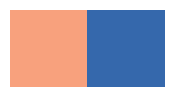

In [ ]:
# color palettes
show_rgba_color_list(colors.BasePalettes.get("binary", 2))

### Next, a qualitative colorscale is derived from cmcrameri's *batlow* scale

This palette is used by plots that assign different levels to colors. The colors are sampled at increments for maximum separability. Note that perceptual uniformity is not observed here, since these colors are meant for categorical levels, not representing numerical data.

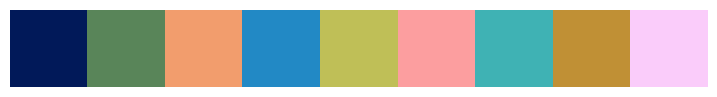

In [ ]:
show_rgba_color_list(colors.BasePalettes.get("qualitative"))

### A diverging colormap for heatmaps:

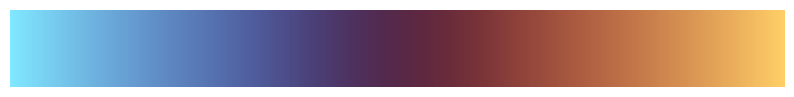

In [ ]:
show_rgba_color_list(list(colors.BaseColormaps.get("diverging")(np.arange(0, 1, 0.001))))

### A sequential colormap for quantitative data

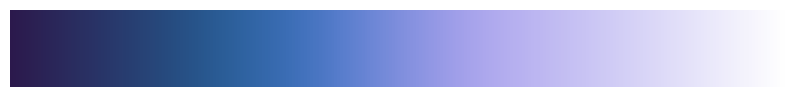

In [ ]:
show_rgba_color_list(list(colors.BaseColormaps.get("sequential")(np.arange(0, 1, 0.001))))

An important consideration for diverging data representation are extreme values: extreme outliers can squish the entire colormap into three values, making a potential heatmap less insightful. We can cap these colormaps by using the MappedColormaps functionality of the `colors` module:

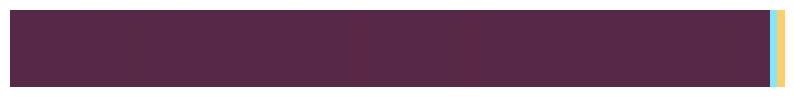

In [ ]:
test_data = [*list(np.random.rand(100)), -100, 100]

# map colormaps to numerical values without capping
mapped_colors = colors.MappedColormaps(cmap="diverging", percentile=None).fit_transform(test_data)
show_rgba_color_list(mapped_colors)

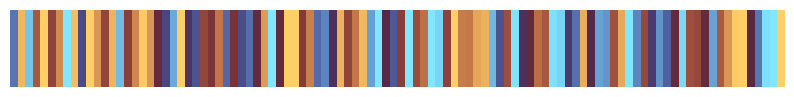

In [ ]:
# map colormaps to numerical values with capping between 5th and 95th percentile
mapped_colors = colors.MappedColormaps(cmap="diverging", percentile=(5, 95)).fit_transform(data=test_data)
show_rgba_color_list(mapped_colors)

## Generating plots

AlphaTools wraps on matplotlib's subplots() in its `create_figure()` method, with two important changes: First, instead of axes we return an instance of `alphatools`' `AxesManager` which is a *generator* that returns subplots - while this might sound complicated on the surface, it is actually extremely easy:

```
fig, axm = create_figure(nrows=2, ncols=2)
```

Because axm is an `AxisManager` instance, we can hop from subplot to subplot by simply calling `axm.next()`. In the 2x2 panel indicated above, this amounts to row-wise steps. We can break the process down like this:


If we call:
```
ax = axm.next()
```
it takes us here in the subplots panel

|X|_|
|-|-|
|_|_|

--> now, we are working with ax as we would: run `alphatools` plotting functions on it, or simply use matplotlib's builtin functions like `ax.scatter()` and `ax.bar()`, etc. If we call
```
ax = axm.next()
```
again, `ax` is now this subplot:

|_|X|
|-|-|
|_|_|

--> we can add another plot to it and continue with `next()` until we run out of panels.

Alternatively, we can access each subplot using indices like `axm[2,1]` to get here:

|_|_|
|-|-|
|X|_|

But experience has shown that this is rarely ever needed - most of the time, simply calling `.next()` and working with the resulting axes object is more convenient! 

It is much easier understood with an example, so try it yourself in the cell below!

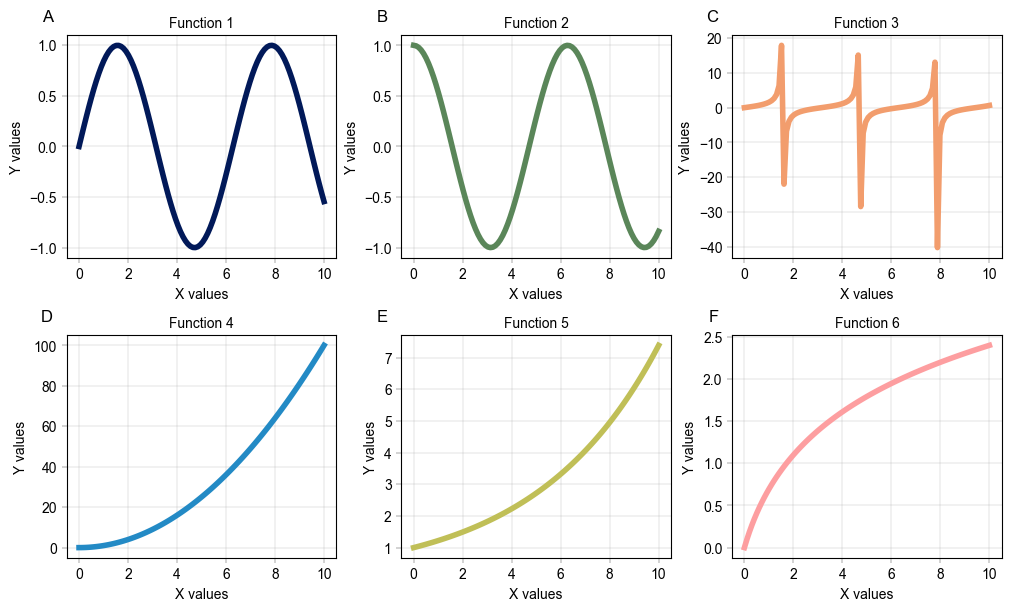

In [ ]:
# Create a 2x3 grid of subplots. Return an instance of AxisManager
fig, axm = create_figure(nrows=2, ncols=3, figsize=(10, 6))

# Example dataset
x = np.linspace(0, 10, 100)
y_funcs = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: np.tan(x),
    lambda x: x**2,
    lambda x: np.exp(x / 5),
    lambda x: np.log(x + 1),
]

# Get qualitative palette, in this case use spectral
n_colors = len(y_funcs)
palette = colors.BasePalettes.get("qualitative", n_colors)

# Iterate through all axes using next() and plot the different functions
for i, func in enumerate(y_funcs):
    ax = axm.next()

    # Use matplotlib's line plotting function
    ax.plot(x, func(x), color=palette[i], lw=4)

    # LEGO-principle: plotting and labelling are different functions, allowing us to combine
    # matplotlib with alphatools' labelling function.
    label_axes(
        ax,
        xlabel="X values",
        ylabel="Y values",
        title=f"Function {i + 1}",
        enumeration=list(string.ascii_uppercase)[i],  # add enumeration
    )


plt.show()

# Save the figure
save_figure(
    fig=fig,
    filename="example_figure.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Let's make some more example data and showcase the remaining plots!

In [ ]:
# Set up reproducible random number generation
rng = np.random.default_rng(seed=42)

example_df = pd.DataFrame(
    {
        "values": np.concatenate([rng.normal(i, size=200) + rng.normal(i) for i in range(3)]),
        "values2": np.concatenate([rng.normal(i, size=200) + rng.normal(i) for i in range(3)]),
        "levels": [i for i in range(3) for _ in range(200)],
        "levels2": np.arange(0, 600),
        "levels3": [i for i in [1, 5, 30] for _ in range(200)],
    }
)
example_df.index = example_df.index.astype(str)
# Introduce random NaN values into every column of example_df
for col in example_df.columns:
    example_df.loc[example_df.sample(frac=0.05, random_state=rng.integers(0, 2**32 - 1)).index, col] = np.nan
example_adata = ad.AnnData(
    X=example_df[["values", "values2"]].values,
    obs=example_df[["levels", "levels2", "levels3"]],
    var=example_df[["values", "values2"]].columns.to_frame(),
)

## Basic histogram with dataframe and AnnData

INFO:root:Column 'values' found in: data.var_names. Using that


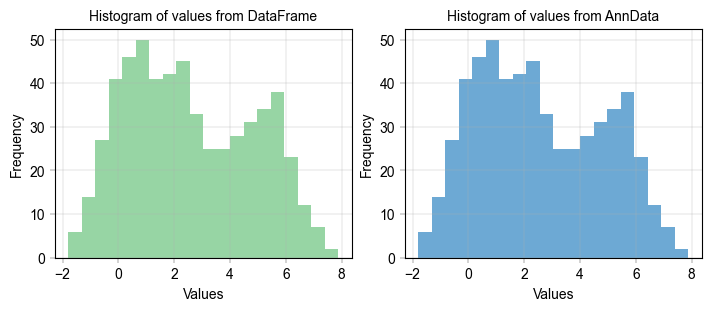

In [ ]:
# with one color
fig, axm = create_figure(1, 2, figsize=(7, 3))

# Show histogram based on DataFrame
ax = axm.next()
Plots.histogram(
    data=example_df,
    value_column="values",
    bins=20,
    color="lightgreen",
    ax=ax,
)
label_axes(ax, xlabel="Values", ylabel="Frequency", title="Histogram of values from DataFrame")

# Show histogram based on AnnData
ax = axm.next()
Plots.histogram(
    data=example_adata,
    value_column="values",
    bins=20,
    color="lightblue",
    ax=ax,
)
label_axes(ax, xlabel="Values", ylabel="Frequency", title="Histogram of values from AnnData")

INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that


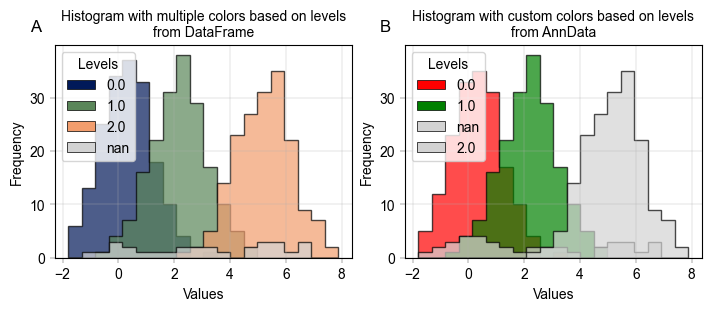

In [ ]:
# with multiple colors based on levels
fig, axm = create_figure(1, 2, figsize=(7, 3))

# Show histogram based on DataFrame
ax = axm.next()
palette = colors.BasePalettes.get("qualitative", example_df["levels"].nunique())
Plots.histogram(
    data=example_df,
    value_column="values",
    color_map_column="levels",
    palette=palette,
    bins=20,
    ax=ax,
    legend="auto",
    hist_kwargs={"alpha": 0.7, "histtype": "stepfilled", "edgecolor": "k"},
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)
label_axes(
    ax,
    xlabel="Values",
    ylabel="Frequency",
    title="Histogram with multiple colors based on levels\nfrom DataFrame",
    enumeration="A",
)

ax = axm.next()
n_colors = example_adata.obs["levels"].nunique()
palette = colors.BasePalettes.get("qualitative", n_colors)

# Introduce some nans
example_adata_copy = example_adata.copy()
example_adata_copy.obs.loc[example_adata_copy.obs.index[:10], "levels"] = np.nan

Plots.histogram(
    data=example_adata_copy,
    value_column="values",
    color_map_column="levels",
    palette=palette,
    color_dict={"0.0": "red", "1.0": "green"},  # custom colors for specific levels, omit level 2
    bins=20,
    ax=ax,
    legend="auto",
    hist_kwargs={"alpha": 0.7, "histtype": "stepfilled", "edgecolor": "k"},
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Frequency",
    title="Histogram with custom colors based on levels\nfrom AnnData",
    enumeration="B",
)

save_figure(
    fig=fig,
    filename="example_histogram.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Basic Scatterplot with DataFrame and AnnData

INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that


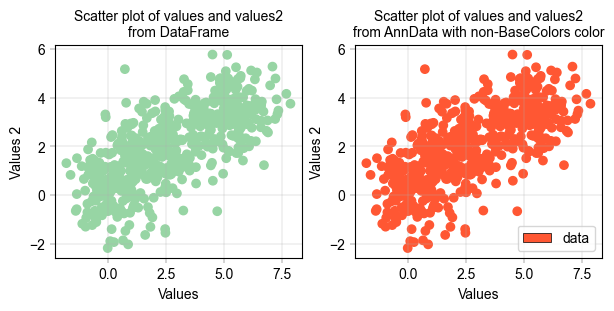

In [ ]:
fig, axm = create_figure(1, 2, figsize=(6, 3))

# Scatterplot based on DataFrame
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color=BaseColors.get("lightgreen"),  # Some color from AlphaTools' BaseColors
    ax=ax,
)

label_axes(ax, xlabel="Values", ylabel="Values 2", title="Scatter plot of values and values2\nfrom DataFrame")

# Scatterplot based on AnnData
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color="#FF5733",  # Some different color that is not in AlphaTools' BaseColors
    ax=ax,
    legend="auto",  # Automatically create a legend
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title="Scatter plot of values and values2\nfrom AnnData with non-BaseColors color",
)

## Conveniently plot multiple levels in one scatterplot

INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that


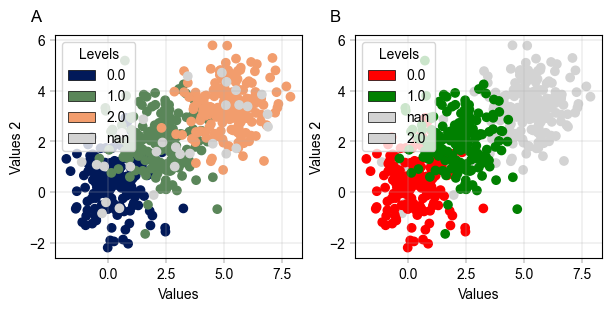

In [ ]:
# with multiple colors based on levels
fig, axm = create_figure(1, 2, figsize=(6, 3))

# Automatic coloring
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels",
    ax=ax,
    legend="auto",
    palette=None,
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    enumeration="A",
)

# Custom coloring
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels",
    ax=ax,
    legend="auto",
    color_dict={
        0.0: "red",
        1.0: "green",
    },  # Custom color dictionary, 2 is not included. We need to be explicit and exactly match the actual levels.
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    enumeration="B",
)

## Heatmap

--> Not yet implemented

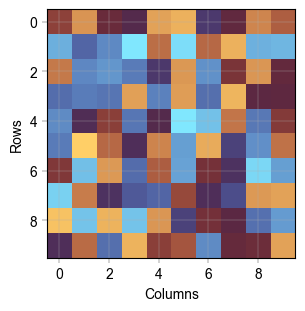

In [ ]:
from alphatools.pl.colors import BaseColormaps
import anndata as ad

fig, axm = create_figure(1, 1, figsize=(3, 3))
ax = axm.next()

arr = np.random.rand(10, 10) - 0.5
annd = ad.AnnData(
    X=arr,
    obs=pd.DataFrame(index=[str(i) for i in range(arr.shape[0])]),
)
ax.imshow(annd.X, cmap=BaseColormaps.get("diverging"))

label_axes(
    ax,
    xlabel="Columns",
    ylabel="Rows",
)

## Particular attention is paid to continuous colorscales that map to values:

The plots below showcase four different cases that can occur with scatterplots, depending on which value should be colored:

- **A**: Scatterplot with three levels, colored with a qualitative palette

- **B**: Scatterplot with many levels, colored with a qualitative palette - but since the palette is finite, we run into repetitions

- **C**: Scatterplot with many levels, colored with a sequential colormap. This means that each level gets a unique shade of color, but the shades do not translate to values: dark blue is not 'less' than light, etc.

- **D**: Scatterplot with three numeric levels that are mapped to a sequential colormap: Now, the difference between the values does matter for coloring - 1. and 5. are dark blue and relatively close together, while 30. is much further apart both numerically and in terms of color.

--> If you want to encode your numerical values in color, supply a **numerical column** to *color_map_column* AND a **colormap** to the *palette* argument. Any other configuration will not preserve the numerical scale in the colorspace.

INFO:root:Column 'levels3' found in: data.obs.columns. Using that
INFO:root:Column 'levels3' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'levels2' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'levels3' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that


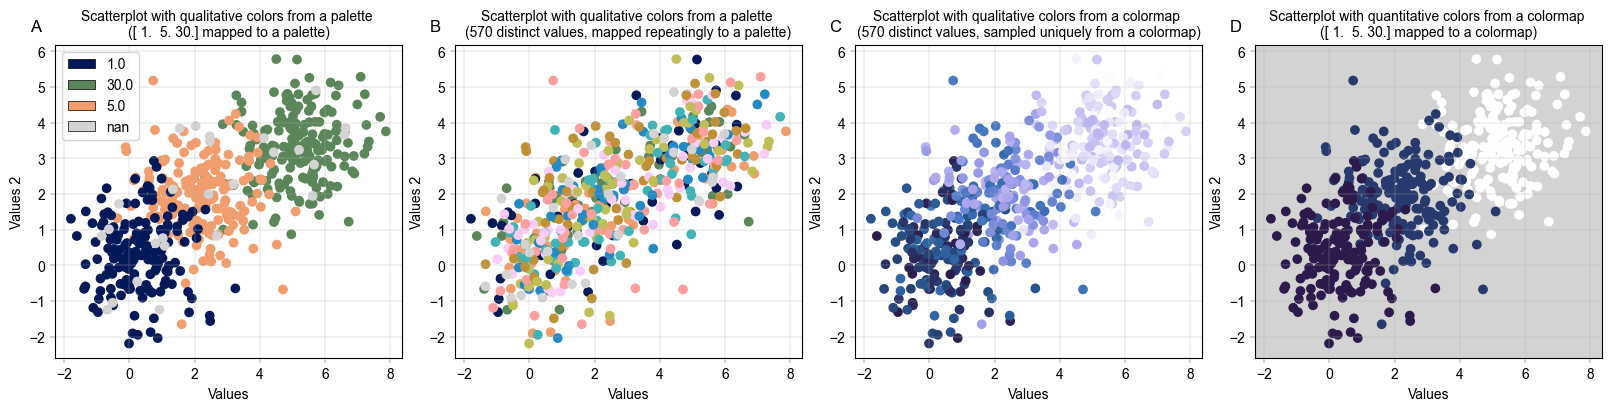

In [ ]:
# with a large number of levels and automatic shift to squential coloring
fig, axm = create_figure(1, 4, figsize=(16, 4))

# Coloring qualitative levels with a palette
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels3",
    legend="auto",
    ax=ax,
    palette=None,
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with qualitative colors from a palette \n({example_adata.obs['levels3'].dropna().unique()} mapped to a palette)",
    enumeration="A",
)

# By default, the standard color palette will just be repeated if there are many distinct values
ax = axm.next()
Plots.scatter(
    data=example_df,
    x_column="values",
    y_column="values2",
    color_map_column="levels2",
    ax=ax,
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with qualitative colors from a palette \n({example_adata.obs['levels2'].nunique()} distinct values, mapped repeatingly to a palette)",
    enumeration="B",
)

# If we want to avoid color repetition, we can use a sequential colormap instead. If the values are not numeric, this will
# simply assign a distinct color to each level with no particular order.
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels2",
    ax=ax,
    palette=colors.BaseColormaps.get("sequential"),
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with qualitative colors from a colormap \n({example_adata.obs['levels2'].nunique()} distinct values, sampled uniquely from a colormap)",
    enumeration="C",
)

# However, when the values are numerical and we care about their quantitative relationship, we can map them to a colormap.
ax = axm.next()
ax.set_facecolor(colors.BaseColors.get("lightgrey"))
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels3",
    legend="auto",
    ax=ax,
    palette=colors.BaseColormaps.get("sequential"),  # force quantitative mapping of the numerical column to a colormap
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with quantitative colors from a colormap \n({example_adata.obs['levels3'].dropna().unique()} mapped to a colormap)",
    enumeration="D",
)

plt.show()

## Labelling data with anchors

A particular challenge of volcanoplots and scatterplots in general is the positioning of labels: When they are attached to the points, they easily overlap. When they 'dodge' each other with connectors, plots can become cluttered and volatile. `alphatools` implements an *anchor* solution: our `label_plot` function can take x-axis anchors. Each label is stacked above its closest anchor point and connected to the datapoint with a line. This way, many labels can be added while keeping the plot tidy and suitable for miniaturization.

INFO:root:Column 'x' found in: data.var_names. Using that
INFO:root:Column 'y' found in: data.var_names. Using that
INFO:root:Column 'x' found in: data.var_names. Using that
INFO:root:Column 'y' found in: data.var_names. Using that


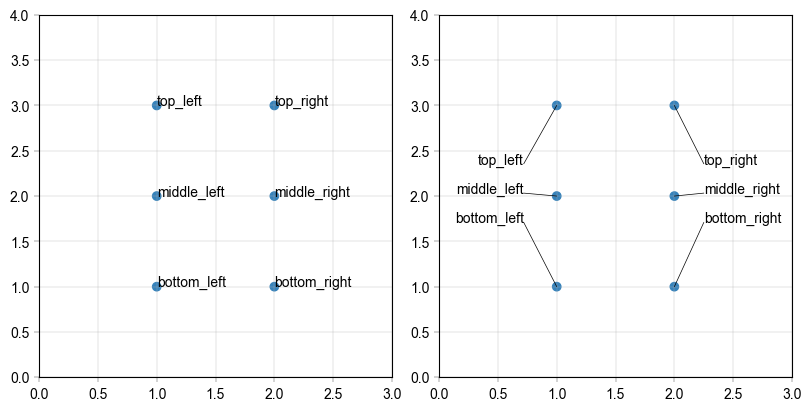

In [ ]:
testdata = ad.AnnData(
    pd.DataFrame(
        {
            "x": [2, 1, 2, 1, 2, 1],
            "y": [2, 2, 3, 3, 1, 1],
        },
        index=["A", "B", "C", "D", "E", "F"],
    )
)

testlabels = pd.DataFrame(
    {
        "label": ["middle_right", "middle_left", "top_right", "top_left", "bottom_right", "bottom_left"],
    },
    index=["A", "B", "C", "D", "E", "F"],
)

testdata = add_metadata(testdata, testlabels, axis=0)

fig, axm = create_figure(1, 2, figsize=(8, 4))

# Labels are extracted from the anndata object
# TODO: change this so that label_plot takes the anndata object directly
label_df = testdata.to_df().join(testdata.obs)

### Label without and with anchors
for x_anchors in [None, (0.72, 2.25)]:
    ax = axm.next()
    Plots.scatter(
        data=testdata,
        x_column="x",
        y_column="y",
        ax=ax,
    )

    label_lines = label_plot(
        ax=ax,
        x_values=label_df["x"],
        y_values=label_df["y"],
        labels=label_df["label"],
        x_anchors=x_anchors,
        y_display_start=2.5,
        y_padding_factor=10,
    )

    ax.set_xlim(0, 3)
    ax.set_ylim(0, 4)

## Showcase anchored labels with differential expression data

In [ ]:
# Set up reproducible random number generation
rng = np.random.default_rng(seed=42)

# example data, should be replaced by actual differential expression results from example file
testx = rng.normal(0, 1, 300)
testy = -np.cos(testx) + rng.normal(0, 0.2, 300)
testp = 10 ** -(testy - min(testy))
vp_data = pd.DataFrame(
    {
        "id": [f"P{10000 + i}" for i in range(300)],
        "gene": [f"gene_{i}" for i in range(300)],
        "log2fc": testx,
        "pval": testp,
        "neg_log10pval": -np.log10(testp),
    }
)
vp_data.index = vp_data["id"].astype(str)
example_adata_diff = ad.AnnData(
    X=vp_data[["log2fc", "pval", "neg_log10pval"]].values,
    obs=vp_data[["id", "gene"]],
    var=vp_data[["log2fc", "pval", "neg_log10pval"]].columns.to_frame(),
)

example_adata_diff.obs["updown"] = example_adata_diff.to_df()["log2fc"].apply(
    lambda x: "up" if x > 1 else ("down" if x < -1 else np.nan)
)

INFO:root:Column 'log2fc' found in: data.var_names. Using that
INFO:root:Column 'neg_log10pval' found in: data.var_names. Using that


(-7.0, 7.0)

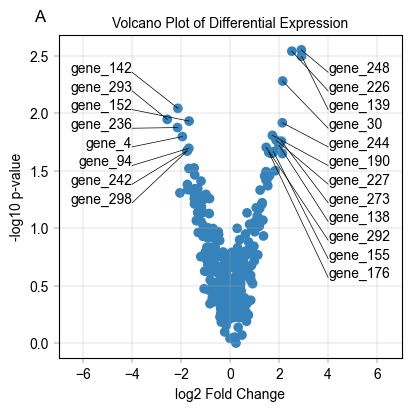

In [ ]:
# Visualize volcanoplot
fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
top_n = 20

Plots.scatter(
    ax=ax,
    data=example_adata_diff,
    x_column="log2fc",
    y_column="neg_log10pval",
)

# Extract points to label
label_data = (
    example_adata_diff.to_df().join(example_adata_diff.obs).sort_values("neg_log10pval", ascending=False).head(top_n)
)

label_plot(
    ax=ax,
    x_values=label_data["log2fc"],
    y_values=label_data["neg_log10pval"],
    labels=label_data["gene"],
    y_display_start=2.5,
    y_padding_factor=5,
    x_anchors=[-4, 4],
)

label_axes(
    ax,
    xlabel="log2 Fold Change",
    ylabel="-log10 p-value",
    title="Volcano Plot of Differential Expression",
    enumeration="A",
)

ax.set_xlim((-7, 7))

## Bar, Box and Violinplot

These are really just different views of the same thing - group-wise quantities plots. Alphatools enables visualization of data here in two modes: either long-data based where there is a grouping column and a value column, or wide-data based where the columns are directly shown. This is crucial for proteomics analyses: sometimes, we want to see e.g. the abundance of one protein in different metadata brackets, e.g. disease and healthy (long data case), sometimes we just want an overview over our protein abundances (wide data case).

A key feature is that columns can be selected seamlessly from obs and X, since frequently grouping information is stored in obs while numerical values are in X.

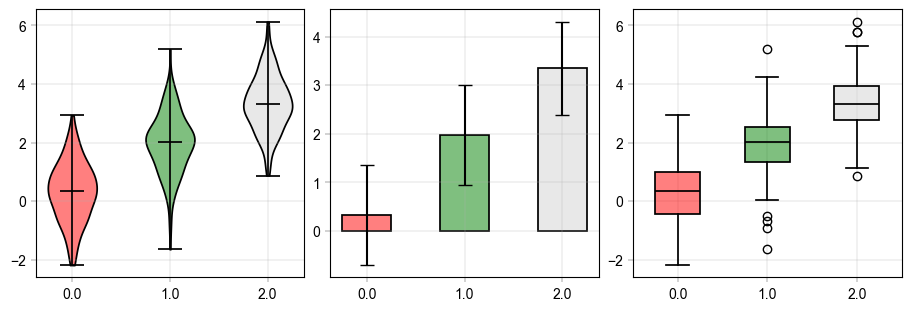

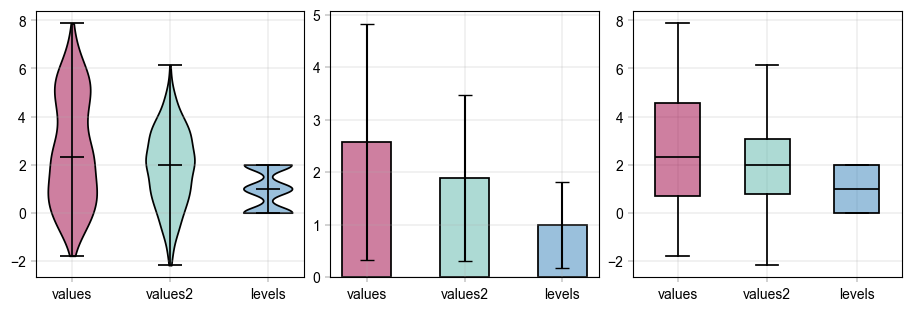

In [ ]:
data = pd.DataFrame(
    {
        "A": [1, 2, 3, 4, 5, 6, 7],
        "B": [17, 3, 4, 5, 6, 7, 8],
    },
    index=list("abcdefg"),
)
md = pd.DataFrame(
    {
        "batch": ["A", "A", "A", "B", "B", "B", "B"],
        "group": ["X", "X", "Y", "Y", "Y", "Z", "Z"],
        "age": [10, 20, 30, 40, 50, 60, 70],
    },
    index=list("abcdefg"),
)

annd = ad.AnnData(X=data.values, obs=md, var=pd.DataFrame(index=data.columns))

# Long data format usage: grouping and values column --> notice that columns can be selected from X and obs
fig, ax = create_figure(1, 3, figsize=(9, 3))

color_dict = {
    0.0: "red",
    1.0: "green",
}  # Custom color dictionary, 2 is not included. We need to be explicit and exactly match the actual levels.

Plots.violinplot(
    ax=ax.next(),
    data=example_adata,
    grouping_column="levels",
    value_column="values2",
    color_dict=color_dict,
)
Plots.barplot(
    ax=ax.next(),
    data=example_adata,
    grouping_column="levels",
    value_column="values2",
    color_dict=color_dict,
)
Plots.boxplot(
    ax=ax.next(),
    data=example_adata,
    grouping_column="levels",
    value_column="values2",
    color_dict=color_dict,
)

# Wide data usage: direct columns --> notice that columns can be selected from X and obs
fig, ax = create_figure(1, 3, figsize=(9, 3))

color_dict = {"values": BaseColors.get("red"), "values2": BaseColors.get("green"), "levels": BaseColors.get("blue")}

Plots.violinplot(
    ax=ax.next(),
    data=example_adata,
    direct_columns=["values", "values2", "levels"],
    color_dict=color_dict,
)
Plots.barplot(
    ax=ax.next(),
    data=example_adata,
    direct_columns=["values", "values2", "levels"],
    color_dict=color_dict,
)
Plots.boxplot(
    ax=ax.next(),
    data=example_adata,
    direct_columns=["values", "values2", "levels"],
    color_dict=color_dict,
)